In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
from skimage.transform import resize

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2023-08-29 15:48:50--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-08-29 15:48:50 (83.6 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



In [4]:
!ls

charmander-tight.png  sample_data


<ipython-input-5-91264be2c73b>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ch = imageio.imread('charmander-tight.png')


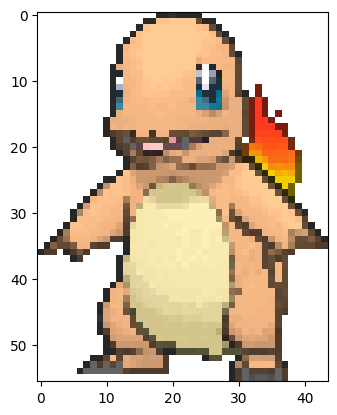

In [5]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [6]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, CH_C = ch.shape

In [7]:
def custom_loss(y_true, y_pred):
  # target is a 5-tuple
  # (row, col, depth, width, object_appeared)
  bce = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])
  return 2 * bce * y_true[:, -1] + 0.5 * bce2

In [8]:


def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(5, activation='sigmoid')(x)
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model



In [9]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2023-08-29 15:48:51--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   413KB/s    in 1.2s    

2023-08-29 15:48:53 (413 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [10]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [11]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

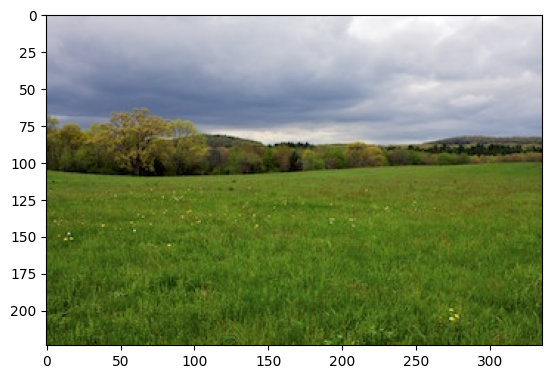

In [12]:
plt.imshow(backgrounds[3])

In [13]:
def pokemon_generator_bg(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 5))

      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

        appear = (np.random.random() < 0.5)
        if appear:

          # resize charmander - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(CH_H * scale)
          new_width = int(CH_W * scale)
          obj = resize(
              ch,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # can't 'just' assign obj to a slice of X
          # since the transparent parts will be black (0)
          mask = (obj[:,:,3] == 0) # find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back

          # make targets
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM

          # later: make the pokemon different sizes
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

        # did the pokemon appear?
        Y[i,4] = appear

      yield X / 255., Y

In [14]:
xx = None
yy = None
for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

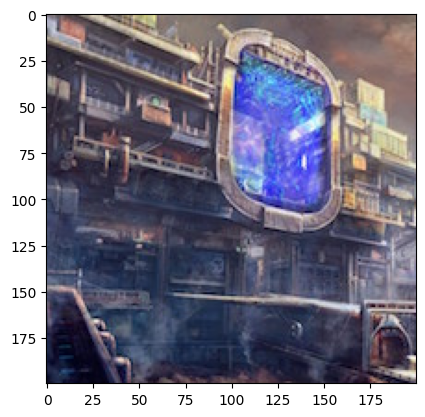

In [15]:
plt.imshow(xx[5]);

In [16]:
model = make_model()
model.fit_generator(
    pokemon_generator_bg(),
    steps_per_epoch=50,
    epochs=5,
)

58889256/58889256 [==============================] - 4s 0us/step


<ipython-input-16-36e730c98c0b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/5
50/50 [==============================] - 70s 673ms/step - loss: 1.2980
Epoch 2/5
50/50 [==============================] - 33s 666ms/step - loss: 0.5920
Epoch 3/5
50/50 [==============================] - 33s 652ms/step - loss: 0.5572
Epoch 4/5
50/50 [==============================] - 33s 660ms/step - loss: 0.5657
Epoch 5/5
50/50 [==============================] - 33s 659ms/step - loss: 0.5390


In [17]:
# Make predictions
def pokemon_prediction_bg():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

  appear = (np.random.random() < 0.5)
  if appear:

    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(CH_H * scale)
    new_width = int(CH_W * scale)
    obj = resize(
        ch,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))

  # Draw the box
  if p[4] > 0.5:
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred:", row0, col0, row1, col1)
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

true: 24 10 96 66
1/1 [==============================] - 0s 20ms/step
pred: 22 6 97 65


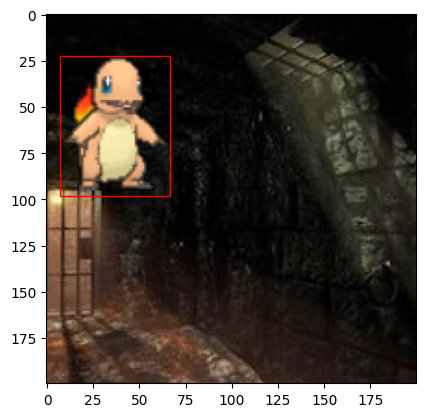

In [20]:
pokemon_prediction_bg()